#### Import libraries and packages

In [1]:
import psycopg2
import psycopg2.extras as extras
import pandas as pd
import numpy as np
import seaborn as sns
from difflib import SequenceMatcher

#### Set connection with postgres database

In [2]:
host = 'postgresfib.fib.upc.edu'
dbname = 'ADSDBjordi.cluet'
user = 'jordi.cluet'
pwd = 'DB151199'
port = 6433
sslmode = 'require'

conn = psycopg2.connect("host='{}' port={} dbname='{}' user={} password={}".format(host, port, dbname, user, pwd))
cursor = conn.cursor()

#### Query data from trusted zone

In [51]:
sql = "SELECT * from trusted_zone.zenodo_fotocasa_2020_21_12_06;"
housing = pd.read_sql_query(sql, conn)

sql = "SELECT * from trusted_zone.ajunt_crime_2020_21_12_06;"
crime = pd.read_sql_query(sql, conn)

sql = "SELECT * from trusted_zone.AJUNT_BARRIS_2017_21_12_06;"
barris = pd.read_sql_query(sql, conn)

sql = "SELECT * from trusted_zone.ajunt_districtes_2021_21_12_24;"
districts = pd.read_sql_query(sql, conn)

In [52]:
len(housing)

9398

In [53]:
len(barris)

73

In [54]:
len(crime)

10

In [55]:
len(districts)

10

#### Entity resolution

In [56]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

def entity(df1,df2,col1,col2):
    names_1 = df1[col1].unique()
    names_2 = df2[col2].unique()

    matching = {}
    for name in names_1:
        best = 0
        best_name = 'None'
        for name1 in names_2:
            distance = similar(name,name1)
            if distance > best:
                best = distance
                best_name = name1
        matching[name] = best_name

    for key in matching:
        df1.loc[df1[col1] == key, col1] = matching[key]
    return df1, matching

In [57]:
housing, matching = entity(housing,barris,'neighbourhood','nom_barri')
crime, matching2 = entity(crime,barris,'districte','nom_districte')
districts, matching3 = entity(districts,barris,'districte','nom_districte')

In [58]:
len(housing)

9398

In [59]:
matching

{'sant antoni': 'Sant Antoni',
 "la nova esquerra de l'eixample": "la Nova Esquerra de l'Eixample",
 'sant gervasi - galvany': 'Sant Gervasi - Galvany',
 'el raval': 'el Raval',
 "l'antiga esquerra de l'eixample": "l'Antiga Esquerra de l'Eixample",
 'el besòs i el maresme': 'el Besòs i el Maresme',
 'sant gervasi - la bonanova': 'Sant Gervasi - la Bonanova',
 'la vila de gràcia': 'la Vila de Gràcia',
 'el poble sec - aei parc montjuïc': 'el Poble Sec',
 'les roquetes': 'les Roquetes',
 'les tres torres': 'les Tres Torres',
 'la bordeta': 'la Bordeta',
 'pedralbes': 'Pedralbes',
 'sant andreu': 'Sant Andreu',
 'navas': 'Navas',
 'sarrià': 'Sarrià',
 'sant pere, santa caterina i la ribera': 'Sant Pere, Santa Caterina i la Ribera',
 'sants': 'Sants',
 "la dreta de l'eixample": "la Dreta de l'Eixample",
 'les corts': 'les Corts',
 'la sagrada família': 'la Sagrada Família',
 'el putxet i el farró': 'el Putxet i el Farró',
 'el barri gòtic': 'el Barri Gòtic',
 "el camp d'en grassot i gràcia

In [60]:
matching2

{'Ciutat Vella': 'Ciutat Vella',
 "L'Eixample": 'Eixample',
 'Sants-Montjuïc': 'Sants-Montjuïc',
 'Les Corts': 'Les Corts',
 'Sarrià-Sant Gervasi': 'Sarrià-Sant Gervasi',
 'Gràcia': 'Gràcia',
 'Horta-Guinardó': 'Horta-Guinardó',
 'Nou Barris': 'Nou Barris',
 'Sant Andreu': 'Sant Andreu',
 'Sant Martí': 'Sant Martí'}

#### Merging datasets

In [61]:
barris = barris.rename(columns={"nom_barri": "neighbourhood",'nom_districte':'districte'})

In [62]:
len(barris)

73

In [63]:
housing = pd.merge(housing,barris,on='neighbourhood')
len(housing)

9398

In [64]:
housing = pd.merge(housing,districts,on='districte')
len(housing)

9398

In [65]:
housing = pd.merge(housing,crime,on='districte')
len(housing)

9398

#### Check quality

In [66]:
housing.isna().any().any()

False

In [67]:
housing['districte'].value_counts()

Eixample               2570
Ciutat Vella           1898
Sarrià-Sant Gervasi    1340
Sants-Montjuïc          816
Sant Martí              795
Gràcia                  792
Les Corts               520
Horta-Guinardó          337
Sant Andreu             234
Nou Barris               96
Name: districte, dtype: int64

<AxesSubplot:xlabel='count', ylabel='districte'>

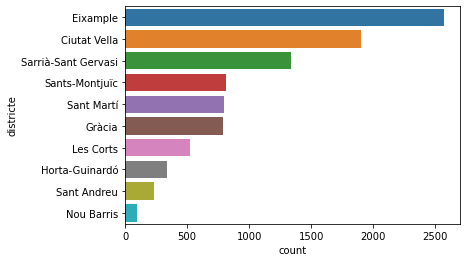

In [68]:
sns.countplot(y = 'districte', data = housing, orient = 'h', order=housing['districte'].value_counts().index)

#### Remove useless columns for analysis

In [69]:
housing.columns

Index(['id', 'address', 'bathrooms', 'building_subtype', 'conservation_state',
       'discount', 'floor_elevator', 'price', 'real_estate', 'real_estate_id',
       'rooms', 'sq_meters', 'neighbourhood', 'neighbourhood_mean_price',
       'price_per_sqm', 'codi_districte', 'districte', 'codi_barri',
       'superficie', 'poblacio', 'furt', 'estafes', 'danys', 'rob_viol_intim',
       'rob_en_vehicle', 'rob_força', 'lesions', 'aprop_indeg', 'amenaces',
       'rob_de_vehicle', 'ocupacions', 'salut_pub', 'abusos_sex',
       'entrada_domicili', 'agressio_sex', 'conviv_veinal', 'vigilancia_poli',
       'molesties_espai_pub', 'contra_prop_priv', 'incendis', 'estupefaents',
       'agressions', 'proves_alcohol', 'proves_droga'],
      dtype='object')

In [70]:
housing.drop(['codi_barri', 'codi_districte', 'address', 'real_estate', 'real_estate_id', 'neighbourhood_mean_price'], axis=1, inplace=True)

In [71]:
housing.columns

Index(['id', 'bathrooms', 'building_subtype', 'conservation_state', 'discount',
       'floor_elevator', 'price', 'rooms', 'sq_meters', 'neighbourhood',
       'price_per_sqm', 'districte', 'superficie', 'poblacio', 'furt',
       'estafes', 'danys', 'rob_viol_intim', 'rob_en_vehicle', 'rob_força',
       'lesions', 'aprop_indeg', 'amenaces', 'rob_de_vehicle', 'ocupacions',
       'salut_pub', 'abusos_sex', 'entrada_domicili', 'agressio_sex',
       'conviv_veinal', 'vigilancia_poli', 'molesties_espai_pub',
       'contra_prop_priv', 'incendis', 'estupefaents', 'agressions',
       'proves_alcohol', 'proves_droga'],
      dtype='object')

### Load integrated table into exploitation zone

##### Create exploitation_zone schema if it does not exist

In [72]:
create_exploitation_zone = """CREATE SCHEMA IF NOT EXISTS exploitation_zone;"""
cursor.execute(create_exploitation_zone)
conn.commit()

##### Create new table in PostgreSQL database

In [73]:
housing.columns

Index(['id', 'bathrooms', 'building_subtype', 'conservation_state', 'discount',
       'floor_elevator', 'price', 'rooms', 'sq_meters', 'neighbourhood',
       'price_per_sqm', 'districte', 'superficie', 'poblacio', 'furt',
       'estafes', 'danys', 'rob_viol_intim', 'rob_en_vehicle', 'rob_força',
       'lesions', 'aprop_indeg', 'amenaces', 'rob_de_vehicle', 'ocupacions',
       'salut_pub', 'abusos_sex', 'entrada_domicili', 'agressio_sex',
       'conviv_veinal', 'vigilancia_poli', 'molesties_espai_pub',
       'contra_prop_priv', 'incendis', 'estupefaents', 'agressions',
       'proves_alcohol', 'proves_droga'],
      dtype='object')

In [80]:
sqlCreateTable = """CREATE TABLE IF NOT EXISTS exploitation_zone.housing_view (
    ID INTEGER PRIMARY KEY,
    BATHROOMS INTEGER,
    BUILDING_SUBTYPE VARCHAR(30),
    CONSERVATION_STATE VARCHAR(20),
    DISCOUNT INTEGER,
    FLOOR_ELEVATOR BOOLEAN,
    PRICE FLOAT,
    ROOMS INTEGER,
    SQ_METERS FLOAT,
    NEIGHBOURHOOD VARCHAR(45),
    PRICE_PER_SQM FLOAT,
    DISTRICTE VARCHAR(50),
    SUPERFICIE FLOAT,
    POBLACIO INTEGER,
    FURT INTEGER,
    ESTAFES INTEGER,
    DANYS INTEGER,
    ROB_VIOL_INTIM INTEGER,
    ROB_EN_VEHICLE INTEGER,
    ROB_FORÇA INTEGER,
    LESIONS INTEGER,
    APROP_INDEG INTEGER,
    AMENACES INTEGER,
    ROB_DE_VEHICLE INTEGER,
    OCUPACIONS INTEGER,
    SALUT_PUB INTEGER,
    ABUSOS_SEX INTEGER,
    ENTRADA_DOMICILI INTEGER,
    AGRESSIO_SEX INTEGER,
    CONVIV_VEINAL INTEGER,
    VIGILANCIA_POLI INTEGER,
    MOLESTIES_ESPAI_PUB INTEGER,
    CONTRA_PROP_PRIV INTEGER,
    INCENDIS INTEGER,
    ESTUPEFAENTS INTEGER,
    AGRESSIONS INTEGER,
    PROVES_ALCOHOL INTEGER,
    PROVES_DROGA INTEGER
);"""
cursor.execute(sqlCreateTable)
conn.commit()

##### Insert rows into table

In [81]:
def execute_values(conn, df, table):
  
    tuples = [tuple(x) for x in df.to_numpy()]
  
    cols = ','.join(list(df.columns))
    # SQL query to execute
    query = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("The dataframe was correctly inserted")
    cursor.close()

In [82]:
execute_values(conn, housing, 'exploitation_zone.housing_view')

The dataframe was correctly inserted


##### Check correct insertion

In [83]:
sql = "SELECT * from exploitation_zone.housing_view;"
pd.read_sql_query(sql, conn)

,id,bathrooms,building_subtype,conservation_state,discount,floor_elevator,price,rooms,sq_meters,neighbourhood,...,agressio_sex,conviv_veinal,vigilancia_poli,molesties_espai_pub,contra_prop_priv,incendis,estupefaents,agressions,proves_alcohol,proves_droga
0,1,1,Flat,Nearly new,0,True,1250.0,3,93.0,Sant Antoni,...,32,11474,4721,4445,2178,793,451,477,3770,326
1,62,1,Flat,Good,0,False,1200.0,3,80.0,Sant Antoni,...,32,11474,4721,4445,2178,793,451,477,3770,326
2,359,2,Flat,Good,0,True,1200.0,4,125.0,Sant Antoni,...,32,11474,4721,4445,2178,793,451,477,3770,326
3,214,2,Attic,New construction,0,True,1800.0,2,155.0,Sant Antoni,...,32,11474,4721,4445,2178,793,451,477,3770,326
4,228,1,Flat,New construction,150,False,1100.0,4,80.0,Sant Antoni,...,32,11474,4721,4445,2178,793,451,477,3770,326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9393,9023,1,Flat,New construction,45,False,780.0,3,72.0,la Font d'en Fargues,...,24,4784,3062,2827,663,349,195,262,1568,106
9394,10925,1,Flat,New construction,50,False,650.0,2,50.0,la Font d'en Fargues,...,24,4784,3062,2827,663,349,195,262,1568,106
9395,2389,1,Flat,New construction,50,True,850.0,3,65.0,la Vall d'Hebron,...,24,4784,3062,2827,663,349,195,262,1568,106
9396,5538,1,Flat,Good,0,True,775.0,3,75.0,la Vall d'Hebron,...,24,4784,3062,2827,663,349,195,262,1568,106
